In [1]:
# Imports
import pandas as pd # Data manipulation
import numpy as np # Algebric operations
import matplotlib.pyplot as plt # Plots
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../')
from utils import hit_count, TU
from online_perceptron import OnlinePerceptron

In [2]:
# Read the data
data = pd.read_csv('../../Data/all_stocks_5yr.csv')
' '.join(np.unique(data['Name']))

'A AAL AAP AAPL ABBV ABC ABT ACN ADBE ADI ADM ADP ADS ADSK AEE AEP AES AET AFL AGN AIG AIV AIZ AJG AKAM ALB ALGN ALK ALL ALLE ALXN AMAT AMD AME AMG AMGN AMP AMZN ANDV ANSS ANTM AON AOS APA APC APD APH ARE ARNC ATVI AVB AVGO AVY AWK AXP AYI AZO BA BAC BAX BBT BBY BCR BDX BEN BF.B BHF BHGE BIIB BK BLK BLL BMY BRK.B BSX BWA BXP C CA CAG CAH CAT CB CBG CBOE CBS CCI CCL CELG CERN CF CFG CHD CHK CHRW CHTR CI CINF CL CLX CMA CMCSA CME CMG CMI CMS CNC CNP COF COG COH COL COO COP COST COTY CPB CRM CSCO CSRA CSX CTAS CTL CTSH CTXS CVS CVX CXO D DAL DD DE DFS DG DGX DHI DHR DIS DISCA DISCK DISH DLPH DLR DLTR DOV DOW DPS DRE DRI DTE DUK DVA DVN DXC EA EBAY ECL ED EFX EIX EL EMN EMR EOG EQIX EQR EQT ES ESRX ESS ETFC ETN ETR EVHC EW EXC EXPD EXPE EXR F FAST FB FBHS FCX FDX FE FFIV FIS FISV FITB FL FLIR FLR FLS FMC FOX FOXA FRT FTI FTV GD GE GGP GILD GIS GLW GM GOOG GOOGL GPC GPN GPS GRMN GS GT GWW HAL HAS HBAN HBI HCA HCN HCP HD HES HIG HLT HOG HOLX HON HP HPE HPQ HRB HRL HRS HSIC HST HSY HUM IBM IC

## Global parameters

In [3]:
s_window_size = 15
ml_window_size = 5

## Moving average (trend descriptor) and ML 'windownizer'

In [4]:
class TrendDescriptor:
    def __init__(self, init_buffer):
        self._buffer = init_buffer

    def next(self):
        return np.mean(self._buffer)

    def update(self, z):
        self._buffer.pop(0)
        self._buffer.append(z)

        
class Windownizer:
    def __init__(self, window_size=5):
        self.window_size = window_size

    def train_builder(self, series):
        samples_dict = {}
        self._series = series
        for z in range(self.window_size, len(self._series)):
            samples_dict[z] = self._series[(z-self.window_size):(z+1)]
        return pd.DataFrame.from_dict(samples_dict, orient='index')
    
    def next_sample(self):
        return np.array(self._series[-self.window_size:])[None, :]
    
    def update_series(self, z):
        self._series.append(z)

#### Selecting a data serie for analysis (3M)

In [5]:
series = data[data.loc[:, 'Name'] == 'MMM'].loc[:, 'Close'].values.tolist()
series[1:10]

[92.3, 92.54, 93.74, 94.24, 93.89, 93.21, 92.68, 91.98, 92.83]

#### Training and testing splits

In [6]:
train_test_split_perc = 0.9
split_point = round(train_test_split_perc * len(series))
split_point

1132

#### Visualizing original time series and its trend

In [7]:
trend_d = TrendDescriptor(series[:s_window_size])
smoothed = series[:s_window_size]
for i in range(s_window_size + 1, split_point):
    smoothed.append(trend_d.next())
    trend_d.update(series[i])

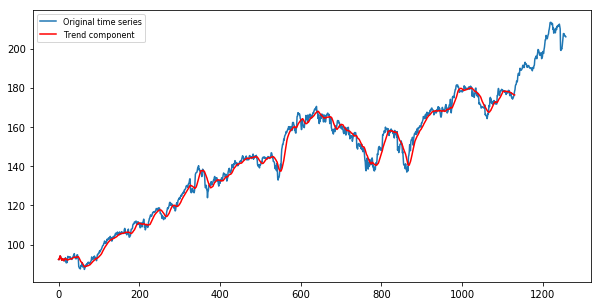

In [8]:
plt.figure(figsize=(10,5))
plt.plot(series, label='Original time series')
plt.plot(smoothed, c='r', label='Trend component')
plt.legend(fontsize=8)
plt.show()

#### Let's see how data looks like after subtracting the trend component

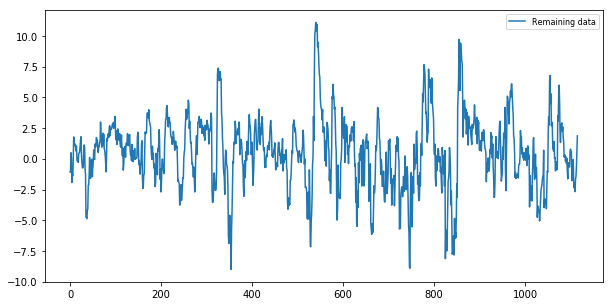

In [9]:
res_series = [a - b for a, b in zip(series[:split_point], smoothed)]
plt.figure(figsize=(10,5))
plt.plot(res_series[s_window_size:], label='Remaining data')
plt.legend(fontsize=8)
plt.show()

In [10]:
# Ignore the first portion of the residual series (== 0)
res_series = res_series[s_window_size:]

#### Preparing the dataset for the ML model

In [11]:
windw = Windownizer(ml_window_size)
training = windw.train_builder(res_series)
training.head(5)

,0,1,2,3,4,5
5,-1.086000,-0.972667,0.492000,0.013333,-1.932000,-1.227333
6,-0.972667,0.492000,0.013333,-1.932000,-1.227333,-1.382000
7,0.492000,0.013333,-1.932000,-1.227333,-1.382000,-0.055333
8,0.013333,-1.932000,-1.227333,-1.382000,-0.055333,1.778000
9,-1.932000,-1.227333,-1.382000,-0.055333,1.778000,1.458000


In [12]:
rf_res = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=2019)
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(training.iloc[:, :-1])
y = scaler_y.fit_transform(training.iloc[:, -1].values[:, None])
rf_res.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=2019, verbose=0, warm_start=False)

#### Getting new predictions

In [13]:
preds = []
for t in range(split_point, len(series)):
    s_aux = trend_d.next()
    trend_d.update(series[t])
    pred = s_aux + scaler_y.inverse_transform(rf_res.predict(scaler_x.transform(windw.next_sample())))
    preds.append(pred[0])
    windw.update_series(series[t] - trend_d.next())

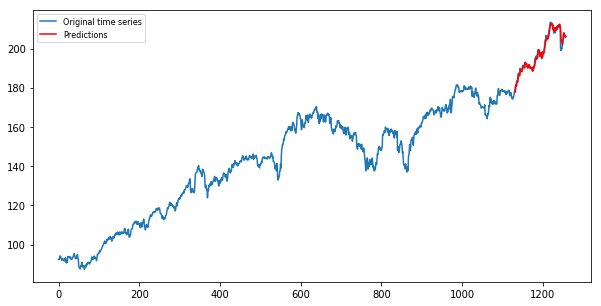

In [14]:
plt.figure(figsize=(10,5))
plt.plot(series, label='Original time series')
plt.plot([t for t in range(split_point, len(series))], preds, c='r', label='Predictions')
plt.legend(fontsize=8)
plt.show()

#### Zooming in

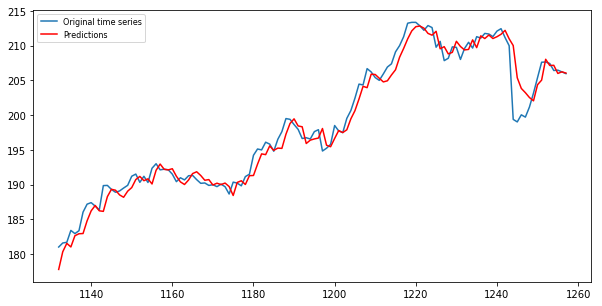

In [15]:
plt.figure(figsize=(10,5))
plt.plot([t for t in range(split_point, len(series))], series[split_point:], label='Original time series')
plt.plot([t for t in range(split_point, len(series))], preds, c='r', label='Predictions')
plt.legend(fontsize=8)
plt.show()

### MSE

In [16]:
def MSE(obs, pred):
    return np.sum([(a - b) ** 2 for a, b in zip(obs, pred)])/len(obs)

In [17]:
MSE(series[split_point:], preds)

3.1418846664725275

In [18]:
hit_count(series[split_point:], preds)/len(preds)

0.49206349206349204

In [19]:
TU(series[split_point:], preds)

1.403479393211646

## Now, let's try it again using a linear model to combine the predictions from both the predictors

In [20]:
# Trend component
trend_d = TrendDescriptor(series[:s_window_size])
smoothed = series[:s_window_size]
for i in range(s_window_size + 1, split_point):
    smoothed.append(trend_d.next())
    trend_d.update(series[i])
    
# Residual series
res_series = [a - b for a, b in zip(series[:split_point], smoothed)]
res_series = res_series[s_window_size:]

windw = Windownizer(ml_window_size)
training = windw.train_builder(res_series)

# The ML model
rf_res = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=2019)
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(training.iloc[:, :-1])
y = scaler_y.fit_transform(training.iloc[:, -1].values[:, None])
rf_res.fit(X, y)

gdr = OnlinePerceptron(learning_rate=0.01, learning_rate_const=True, learning_rate_decay=0.001)
delay = 5

# Using a perceptron to combine both predictors
preds = []
first = True
for t in range(split_point, len(series)):
    s_aux = trend_d.next()
    trend_d.update(series[t])
    if first:
        pred_ml = scaler_y.inverse_transform(rf_res.predict(scaler_x.transform(windw.next_sample())))
        pred = s_aux + pred_ml[0]
        first = False if t >= split_point + delay else True
        gdr.partial_fit([s_aux, pred_ml[0]], series[t])
    else:
        pred_ml = scaler_y.inverse_transform(rf_res.predict(scaler_x.transform(windw.next_sample())))
        new_combx = [s_aux, pred_ml[0]]
        pred = gdr.predict(new_combx)[0]
        gdr.partial_fit(new_combx, series[t])
    preds.append(pred)
    windw.update_series(series[t] - trend_d.next())
    

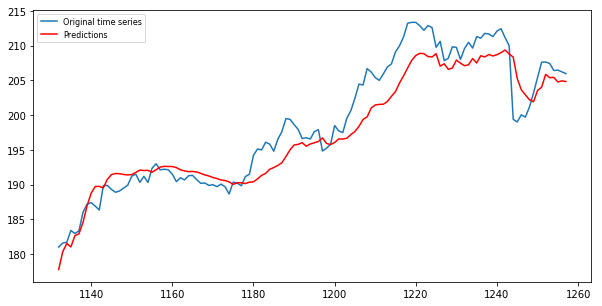

In [21]:
plt.figure(figsize=(10,5))
plt.plot([t for t in range(split_point, len(series))], series[split_point:], label='Original time series')
plt.plot([t for t in range(split_point, len(series))], preds, c='r', label='Predictions')
plt.legend(fontsize=8)
plt.show()

In [22]:
MSE(series[split_point:], preds)

8.946150173509123

In [23]:
hit_count(series[split_point:], preds)/len(preds)

0.5

In [24]:
TU(series[split_point:], preds)

3.9962438884225477

In [25]:
from statsmodels.tsa.arima_model import ARIMA
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction

predictions = []
scaler_arima = StandardScaler()
Actual = scaler_arima.fit_transform(np.array(series[:split_point]).reshape(-1, 1))
test_data = scaler_arima.transform(np.array(series[split_point:]).reshape(-1, 1))

Actual = [a[0] for a in Actual]
test_data = [t[0] for t in test_data]

for timepoint in range(len(test_data)):
    ActualValue = test_data[timepoint]
    Prediction = StartARIMAForecasting(Actual, 1,1,0) 
    predictions.append(Prediction)
    Actual.append(ActualValue)

predictions = scaler_arima.inverse_transform(np.array(predictions).reshape(-1, 1))
predictions = [p for p in predictions]

In [26]:
MSE(series[split_point:], predictions)

2.2887085274791947

In [27]:
hit_count(series[split_point:], predictions)/len(predictions)

0.48412698412698413

In [28]:
TU(series[split_point:], predictions)

9439.370404455716

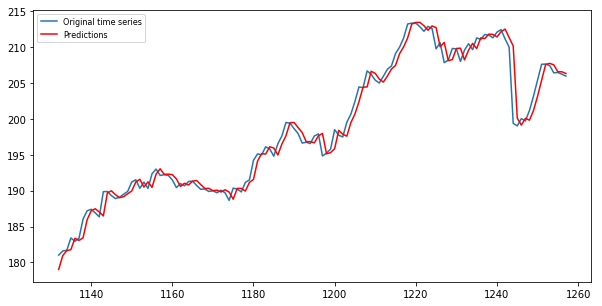

In [29]:
plt.figure(figsize=(10,5))
plt.plot([t for t in range(split_point, len(series))], series[split_point:], label='Original time series')
plt.plot([t for t in range(split_point, len(series))], predictions, c='r', label='Predictions')
plt.legend(fontsize=8)
plt.show()